# Exploration of the RAWFC dataset

In this jupyter notebook, the RAWFC dataset from Yang et al. 2022 (https://aclanthology.org/2022.coling-1.230) is explored. It is a dataset used for factual verification (last step of fake news detection) that is based on verdicts from Snopes.

This notebook looks at the distribution of the data, both in terms of words used and verdicts.

## Import of modules

First, relevant Python modules are imported

In [8]:
%load_ext autoreload
%autoreload

from rawfc_utils import load_rawfc_dataset, RAWFCLabel, label_to_name
import seaborn as sns
from plotting_utils import dataframe_to_text, show_word_cloud, show_bar_plot
import os
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()
check_worthiness = pd.read_csv("../results/RAWFC/checkworthiness.csv", index_col=0)
display(check_worthiness.head())
data = load_rawfc_dataset("../data/RAWFC")
data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,claim,label,check_worthiness
event_id,,,
100116,Both Robert E. Lee and Jefferson Davis disavow...,1,1.0
100242,First Lady Melania Trump again copied words fr...,1,1.0
100262,Anonymous seized the domain of white supremaci...,1,1.0
100307,We check an assortment of claims about the 201...,1,1.0
100562,Iceland has virtually removed the occurrence o...,1,1.0


,claim,label
event_id,,
100116,Both Robert E. Lee and Jefferson Davis disavow...,1
100242,First Lady Melania Trump again copied words fr...,1
100262,Anonymous seized the domain of white supremaci...,1
100307,We check an assortment of claims about the 201...,1
100562,Iceland has virtually removed the occurrence o...,1


## Wordclouds

Generates one wordcloud for the whole dataset, and one for each label. Also generates word clouds for check-worthy and non check-worthy claims according to the predictions from a fine-tuned LLM.

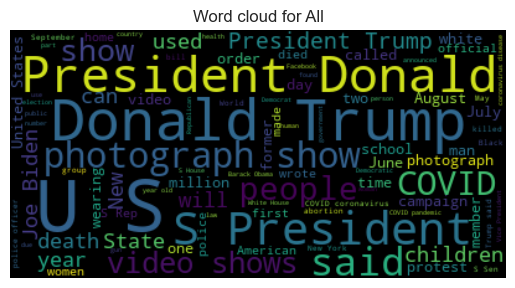

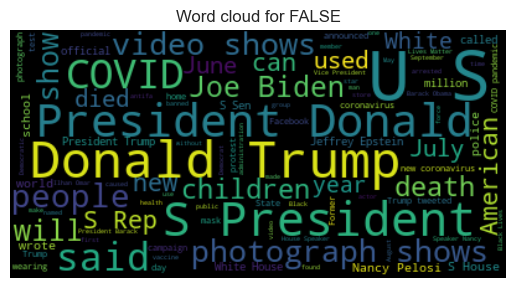

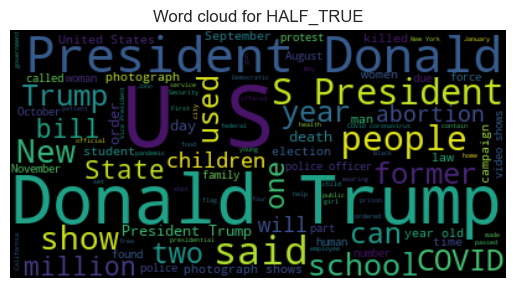

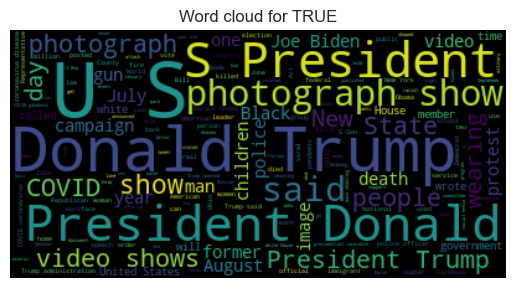

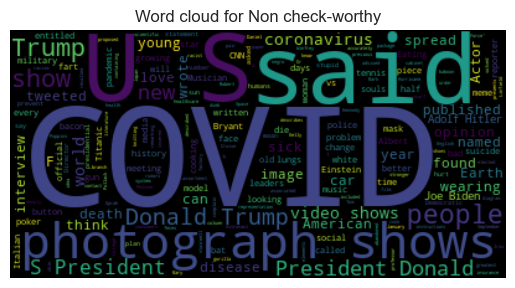

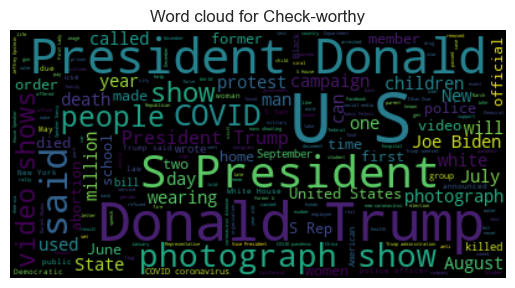

In [23]:
%autoreload
titles = ["All", *RAWFCLabel]
os.makedirs("../figures/rawfc/wordclouds", exist_ok=True)
for title in titles:
    if title == "All":
        text = dataframe_to_text(data, ["claim"])
    else:
        filtered_data = data[data["label"] == title.value]
        text = dataframe_to_text(filtered_data, ["claim"])
    title = f"Word cloud for {title.name if title != 'All' else 'All'}"
    save_path = f"../figures/rawfc/wordclouds/{title}.png"
    show_word_cloud(text, title, file_path=save_path)
check_worthiness_titles = ["Non check-worthy", "Check-worthy"]
check_worthiness_scores = [0, 1]
for score, title in zip(check_worthiness_scores, check_worthiness_titles):
    filtered_data = check_worthiness[check_worthiness["check_worthiness"] == score]
    text = dataframe_to_text(filtered_data, ["claim"])
    title = f"Word cloud for {title}"
    save_path = f"../figures/rawfc/wordclouds/{title}.png"
    show_word_cloud(text, title, file_path=save_path)

## Label distribution 

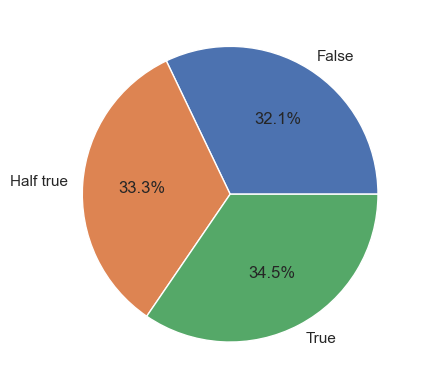

In [4]:
plt.pie(
    [data[data["label"] == label.value].shape[0] for label in RAWFCLabel],
    labels=[label_to_name(label) for label in RAWFCLabel],
    autopct="%.1f%%",
)
plt.savefig("../figures/rawfc/total_distribution.pdf")
plt.show()

## Key words for check-worthiness

Investigating certain keywords that could help explain why claims of certain labels are more likely to be labeled check-worthy

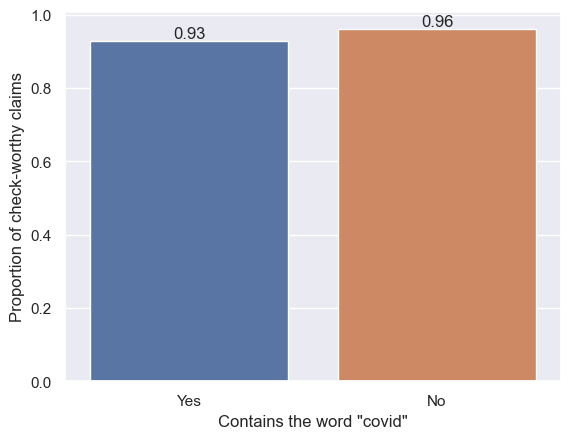

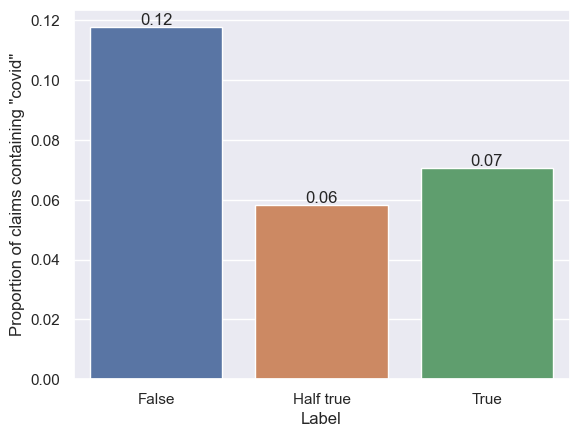

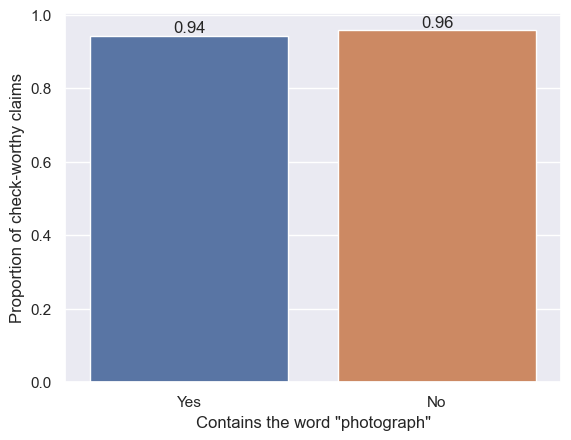

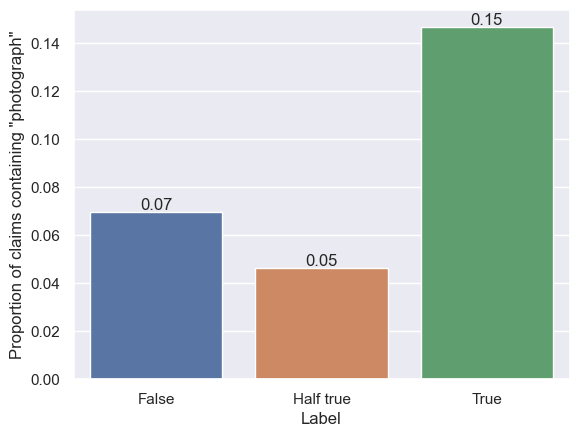

In [21]:

keywords = ["covid", "photograph"]
os.makedirs("../figures/rawfc/keywords", exist_ok=True)

for keyword in keywords:
    contains_word = check_worthiness[check_worthiness["claim"].str.lower().str.contains(keyword)]
    not_contains_word = check_worthiness[~check_worthiness["claim"].str.lower().str.contains(keyword)]
    # Plot the proportion of check-worthy claims
    x = [f"Yes", f"No"]
    y = [contains_word["check_worthiness"].mean(), not_contains_word["check_worthiness"].mean()]
    show_bar_plot(
        x,
        y,
        xlabel=f"Contains the word \"{keyword}\"",
        ylabel="Proportion of check-worthy claims",
        y_ticks=[i*0.1 for i in range(11)],
        use_bar_labels=True,
        file_path=f"../figures/rawfc/keywords/{keyword}-checkworthiness.pdf",
        force_save=True
    )
    # Plot the proportion of claims within each label that uses the word
    x = [label_to_name(label) for label in RAWFCLabel]
    label_proportions = [
        (
            len(check_worthiness.query(f"label == {label.value} and claim.str.lower().str.contains('{keyword}')")) 
            / len(check_worthiness.query(f"label == {label.value}"))
        )
        for label in RAWFCLabel
    ]
    show_bar_plot(
        x,
        label_proportions,
        xlabel="Label",
        ylabel=f"Proportion of claims containing \"{keyword}\"",
        use_bar_labels=True,
        file_path=f"../figures/rawfc/keywords/{keyword}-labels.pdf",
        force_save=True
    )
